In [ ]:
# Install required packages
#!pip install -q kaggle
#"LOCAL DATASET"
!pip install Augmentor

In [ ]:
# Upload kaggle.json file
# from google.colab import files
# files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"divyanshsingh07","key":"10cf8e086be91392dd703ee34d0bb6d7"}'}

In [ ]:
# Set up Kaggle API
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download dataset
# !kaggle datasets download -d ashwingupta3012/human-faces

Dataset URL: https://www.kaggle.com/datasets/ashwingupta3012/human-faces
License(s): CC0-1.0
 99% 1.81G/1.82G [00:22<00:00, 102MB/s]
100% 1.82G/1.82G [00:22<00:00, 87.1MB/s]


In [ ]:
# Extract dataset
# import zipfile
# zip_ref = zipfile.ZipFile('human-faces.zip', 'r')
# zip_ref.extractall('/content')
# zip_ref.close()

In [ ]:
# Import necessary libraries
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import tensorflow as tf
import numpy as np
import os
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive"


 3794493_ForgotPass.pdf   divpics	 'WhatsApp Image 2023-07-31 at 2.03.05 PM.jpeg'
'Colab Notebooks'	 'Epson iPrint'


In [ ]:
!ls "/content/drive/My Drive/divpics"



aug-data


In [ ]:
# # Augment the dataset
# dataset_directory = r'D:\divpics'
# augmented_directory = r'D:\divpics\aug_path'
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

# Check if the directory exists and list files
import os
if os.path.exists(dataset_directory):
    print("Dataset directory exists.")
    print("Listing files in dataset directory:")
    print(os.listdir(dataset_directory))
else:
    print("Dataset directory does not exist.")

# Define the directory where your images are stored on Google Drive
dataset_directory = '/content/drive/My Drive/divpics/class1'
augmented_directory = '/content/drive/My Drive/divpics/aug-data'

# The rest of the code remains the same...


Mounted at /content/drive
Dataset directory exists.
Listing files in dataset directory:
['aug-data']


In [ ]:
# Ensure there are images in the directory
if not os.listdir(dataset_directory):
    print("No images found in dataset directory. Please add images to the directory and try again.")
    raise Exception("No images found in dataset directory. Please add images to the directory and try again.")


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/divpics/class1'

In [ ]:

# Create augmented directory if it does not exist
os.makedirs(augmented_directory, exist_ok=True)

In [ ]:
# Create ImageDataGenerator with augmentation options
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# Flow training images in batches from the dataset directory
train_generator = datagen.flow_from_directory(
    directory=dataset_directory,
    target_size=(264, 264),
    batch_size=32,
    class_mode=None,
    save_to_dir=augmented_directory,
    save_prefix='aug',
    save_format='jpg'
)

Found 0 images belonging to 1 classes.


In [ ]:
# Generate and save augmented images
num_batches_to_generate = 5
for _ in range(num_batches_to_generate):
    train_generator.next()

In [ ]:
print(f'Augmented images saved in: {augmented_directory}')

Augmented images saved in: /content/drive/My Drive/divpics/aug-data


In [ ]:
# Count number of images in a folder
def count_images(folder_path):
    valid_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']
    image_count = len([file for file in os.listdir(folder_path) if any(file.lower().endswith(ext) for ext in valid_extensions)])
    return image_count

In [ ]:
image_count = count_images(dataset_directory)
print(f'The folder contains {image_count} image files.')

The folder contains 7219 image files.


In [ ]:
# Load pre-trained ResNet-50 model
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input


In [ ]:
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = preprocess_input(img)
    return img

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
# Extract features from images
image_paths = [os.path.join(dataset_directory, file) for file in os.listdir(dataset_directory) if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif'))]

In [ ]:
feature_matrix = []
for image_path in image_paths:
    img = preprocess_image(image_path)
    features = resnet_model.predict(np.expand_dims(img, axis=0))
    feature_matrix.append(features)

1/1 [==============================] - 0s 378ms/step


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 177ms/step


In [ ]:
feature_matrix = np.vstack(feature_matrix)
np.save('feature_matrix.npy', feature_matrix) # Save feature matrix for later use

In [ ]:
# Process query image
query_image_path = '/content/Humans/1 (557).jpg'
query_img = preprocess_image(query_image_path)
query_features = resnet_model.predict(np.expand_dims(query_img, axis=0))

#Print the shape of the extracted features:
print(f"Extracted features shape: {query_features.shape}")

1/1 [==============================] - 0s 181ms/step
Extracted features shape: (1, 2048)


In [ ]:
# Calculate cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

similarity_scores = cosine_similarity(query_features, feature_matrix)


# Print the shape of the similarity scores to verify
print(f"Similarity scores shape: {similarity_scores.shape}")

Similarity scores shape: (1, 7219)


In [ ]:
similarity_threshold = 0.9  # Adjust this value as needed

# Find and display similar images above the threshold
sorted_indices = np.argsort(similarity_scores[0])[::-1]
top_indices = [idx for idx in sorted_indices if similarity_scores[0][idx] >= similarity_threshold]
num_similar_images = min(len(top_indices), 5)  # Number of similar images to display

# Retrieve the file paths of the most similar images
similar_image_paths = [image_paths[i] for i in top_indices[:num_similar_images]]

In [ ]:
# Find and display similar images
#sorted_indices = np.argsort(similarity_scores[0])[::-1]
#num_similar_images = 5
#top_indices = sorted_indices[:num_similar_images]
#similar_image_paths = [image_paths[i] for i in top_indices]

In [ ]:
print("Paths of similar images:")
for path in similar_image_paths:
    print(path)


Paths of similar images:
/content/Humans/1 (557).jpg
/content/Humans/1 (2233).jpg
/content/Humans/1 (1551).jpg
/content/Humans/1 (1972).jpg
/content/Humans/1 (405).jpg


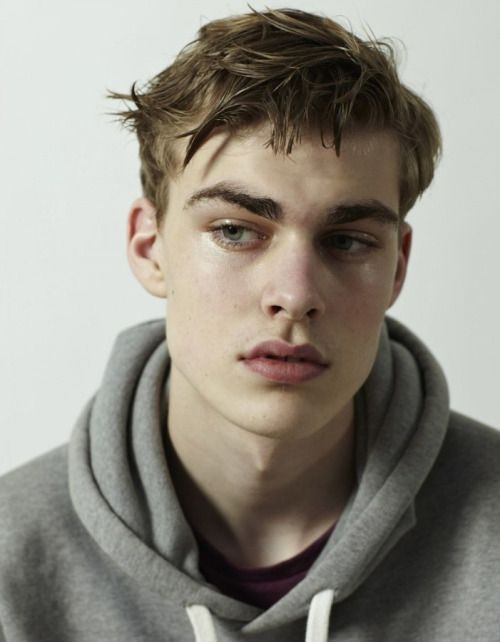

In [ ]:
# Display the query image
query_img_display = load_img('/content/Humans/1 (405).jpg')
query_img_display

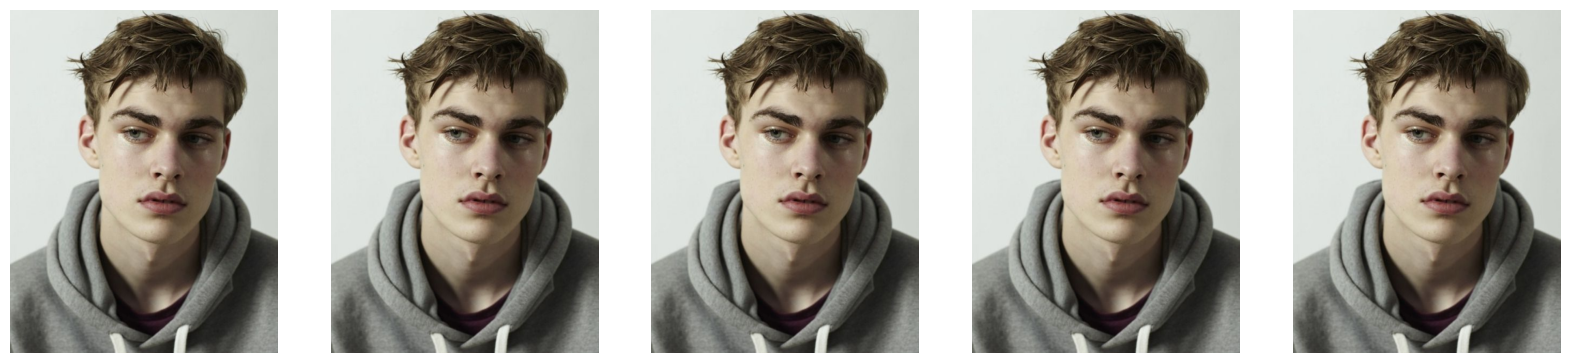

In [ ]:
# Display the similar images
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, num_similar_images, figsize=(20, 5))
for ax, img_path in zip(axes, similar_image_paths):
    img = load_img(img_path)
    ax.imshow(img)
    ax.axis('off')
plt.show()

In [ ]:
#ACCURACY SCORE

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Assuming you have a ground truth dataset
# ground_truth_pairs is a list of tuples (img1_path, img2_path, label)
# where label is 1 for similar images and 0 for dissimilar images
ground_truth_pairs = [
    ('/content/Humans/1 (557).jpg', '/content/Humans/1 (2233).jpg', 1),
    ('/content/Humans/1 (557).jpg', '/content/Humans/1 (1551).jpg', 1),
    ('/content/Humans/1 (557).jpg', '/content/Humans/1 (405).jpg', 1),
    ('/content/Humans/1 (2233).jpg', '/content/Humans/1 (1551).jpg', 1),
    ('/content/Humans/1 (2233).jpg', '/content/Humans/1 (405).jpg', 1),
    ('/content/Humans/1 (1551).jpg', '/content/Humans/1 (405).jpg', 1),
    ('/content/Humans/1 (557).jpg', '/content/Humans/1 (1972).jpg',1),
    ('/content/Humans/1 (2233).jpg', '/content/Humans/1 (1972).jpg', 1),

    # Add more pairs
]

# Extract features for the ground truth pairs
def extract_features(image_paths):
    features = []
    for image_path in image_paths:
        img = preprocess_image(image_path)
        feature = resnet_model.predict(np.expand_dims(img, axis=0))
        features.append(feature)
    return np.vstack(features)

# Calculate cosine similarity between feature vectors
def calculate_similarity(feature1, feature2):
    return cosine_similarity(feature1, feature2)[0][0]

# Initialize lists to store true labels and predicted scores
true_labels = []
predicted_scores = []

# Evaluate similarity for each pair in the ground truth
for img1_path, img2_path, label in ground_truth_pairs:
    feature1 = extract_features([img1_path])
    feature2 = extract_features([img2_path])
    similarity_score = calculate_similarity(feature1, feature2)

    true_labels.append(label)
    predicted_scores.append(similarity_score)

# Convert predicted scores to binary labels using a threshold
threshold = 0.9  # Adjust the threshold based on your requirements
predicted_labels = [1 if score >= threshold else 0 for score in predicted_scores]

# Calculate precision, recall, and F1-score
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')


1/1 [==============================] - 0s 383ms/step
Precision: 1.0
Recall: 1.0
F1-score: 1.0
